In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

### *Only run next cell if you want to generate the data from the logs again*

In [4]:
# Get all the trace files
files = glob.glob("../src/benchmarks/*/logs/arg_trace.log")

benchmark_names = [f.split("/")[3] for f in files]

df = pd.DataFrame()
for file in files:
    benchmark_name = file.split("/")[3]
    print(benchmark_name)
    f = open(file, "r")
    file_data = {"call_id": [], "ts": [], "op": [], "args": []}
    # read every line and split it by spaces
    counter = 0
    for line in f:
        if line == '\n': continue
        splitted_line = line.split(" ")
        # First element is in between []
        file_data["ts"].append(splitted_line[0][1:-1])
        # Remove from second element everything that comes after the parenthesis
        file_data["op"].append(splitted_line[1].split("(")[0])

        # For now, put the rest in the arg
        # If parenthesis in the string, add everything that is after the first
        # parenthesis
        if "(" in line:
            file_data["args"].append(line[line.find('('):].strip())
        elif len(splitted_line) > 2:
            file_data["args"].append(" ".join(splitted_line[2:]).strip())
        else:
            raise Exception("Parsing error: ", line)
        
        file_data["call_id"].append(counter)
        counter += 1
        

    file_df = pd.DataFrame(file_data)
    # Multi level indexing, first level is the benchmark name

    file_df["benchmark"] = benchmark_name
    df = pd.concat([df, file_df])

df.set_index(["benchmark", "call_id"], inplace=True)
df.to_pickle("traces.pkl")

latency
hotspot
bfs
yolop
dwt2d
gaussian
myocyte
resnext101
midas
vgg19
resnet50-py
alexnet
resnext50
srad_v1
pathfinder


# Sequence analysis

In [5]:
df = pd.read_pickle("traces.pkl")
# remove "Number" operation (trace from cudnn get algo)
df = df.drop(df[df.op == "Number"].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 52569 entries, ('latency', 0) to ('pathfinder', 20)
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ts      52569 non-null  object
 1   op      52569 non-null  object
 2   args    52569 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


In [6]:
# Quickly look at most used operations
df["op"].value_counts().index

Index(['cudaMemcpy', 'Synchronization', 'cudaLaunchKernel', 'cudaMemcpyAsync',
       'cudaStreamSynchronize', 'cudaThreadSynchronize',
       'cudnnSetTensorNdDescriptor', 'cudnnCreateTensorDescriptor',
       'cudnnDestroyTensorDescriptor', 'cudnnSetConvolutionMathType',
       'cudnnSetStream', 'cublasLtMatmulDescSetAttribute',
       'cudnnCreateFilterDescriptor', 'cudnnSetFilterNdDescriptor',
       'cudnnCreateConvolutionDescriptor', 'cudnnSetConvolutionNdDescriptor',
       'cudnnSetConvolutionGroupCount', 'cudnnDestroyConvolutionDescriptor',
       'cudnnDestroyFilterDescriptor', 'cudnnConvolutionForward',
       'cudnnBatchNormalizationForwardInference', 'cublasLtMatrixLayoutCreate',
       'cublasLtMatrixLayoutDestroy', 'cudaMalloc',
       'cudnnGetConvolutionForwardAlgorithm_v7', 'cublasSetStream_v2',
       'cublasSetMathMode', 'cublasLtMatmulDescCreate',
       'cublasLtMatmulDescDestroy', 'cublasLtMatmulPreferenceDestroy',
       'cublasLtMatmulPreferenceCreate',
       

In [7]:
# Look at the benchmark with the most synchronous calls
df.loc[df["op"] == "Synchronization"].groupby("benchmark").count().sort_values("op", ascending=False)['op']

benchmark
myocyte        7808
yolop           368
srad_v1         225
midas           115
resnext101       51
resnet50-py      44
resnext50        39
vgg19            25
bfs              15
alexnet          13
gaussian          9
hotspot           7
pathfinder        7
Name: op, dtype: int64

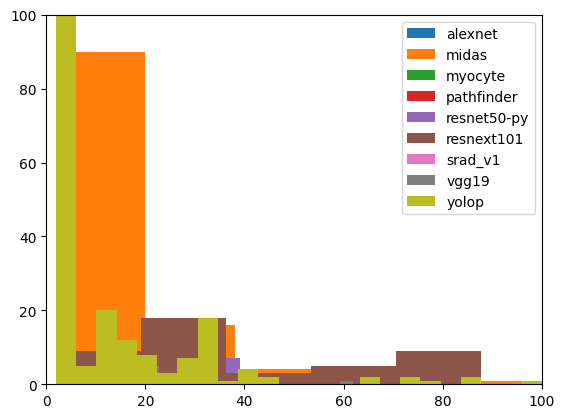

In [231]:
# Look at the distribution of the distance between synchronous calls in the benchmarks
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]
for group in dist.groupby("benchmark"):
    group_name = group[0]
    plt.hist(group[1], bins=100, label=group_name)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()

# for benchmark in dist.index.levels[0]:
    # dist.loc[benchmark].plot.hist(bins=100, alpha=0.5, label=benchmark)

In [6]:
# Number of consecutive diff in synchronous calls
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]

"Percentage of same consecutive in between synch calls lenght", (dist.diff() == 0).sum() / len(dist)

('Percentage of same consecutive in between synch calls lenght',
 0.03469411356539841)

In [238]:
df

ts               op  \
benchmark  call_id                                         
latency    0        23:31:55:398:398487       cudaMalloc   
           1        23:31:56:617:617045       cudaMemcpy   
           2        23:31:56:617:617084       cudaMemcpy   
hotspot    0        23:30:44:926:926885       cudaMalloc   
           1        23:30:46:112:112985       cudaMalloc   
...                                 ...              ...   
pathfinder 16       12:32:53:078:078479         cudaFree   
           17       12:32:53:078:078710  Synchronization   
           18       12:32:53:078:078720         cudaFree   
           19       12:32:53:078:078733  Synchronization   
           20       12:32:53:078:078737         cudaFree   

                                                                 args  
benchmark  call_id                                                     
latency    0                                        (D0 (0), 4 bytes)  
           1        (cudaMemcpyHostToDevice) D1(0x7f2645600000) <-...  
           2        (cudaMemcpyDeviceToHost, H0(0x7ffeaf8d3554) <-...  
hotspot    0                                   (D0 (0), 100000 bytes)  
           1                                   (D0 (0), 100000 bytes)  
...                                                               ...  
pathfinder 16                             ( devPtr:{0x7ffa32000000} )  
           17                                                      5.  
           18                             ( devPtr:{0x7ffa37600000} )  
           19                                                      6.  
           20                             ( devPtr:{0x7ffa37661c00} )  

[50410 rows x 3 columns]

In [8]:
# Look if they are repetitive patterns with the synch calls as a starting point
unique_operations = df["op"].unique()
op_to_id_map = {op: value for value, op in zip(range(len(unique_operations)), unique_operations)}
df = df.assign(op_id=lambda x: x["op"].map(op_to_id_map))

# Insert nan for sequence
df["sequence"] = np.nan

for benchmark in df.index.levels[0]:
    print(benchmark)
    benchmark_df = df.loc[benchmark]
    pattern_data = {'call_id': [], 'sequence': [], 'sequence_call_id': []}
    sequence = []
    sequence_call_id = []
    for idx, row in benchmark_df.iterrows():
        if row["op"] == "Synchronization":
            pattern_data['call_id'].append(idx)
            pattern_data['sequence'].append(sequence)
            pattern_data['sequence_call_id'].append(sequence_call_id)
            sequence = []
            sequence_call_id = []
        else:
            sequence.append(row["op_id"])
            sequence_call_id.append(idx)

    df.loc[(benchmark, pattern_data['call_id']), 'sequence'] = pattern_data['sequence']
    df.loc[(benchmark, pattern_data['call_id']), 'sequence_call_id'] = pattern_data['sequence_call_id']

alexnet
bfs
dwt2d
gaussian


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

hotspot
latency
midas


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

myocyte


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

pathfinder
resnet50-py
resnext101


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

resnext50


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

srad_v1
vgg19
yolop


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

In [9]:
# count the amount of similar sequences in each benchmark
for benchmark in df.index.levels[0]:
    print(benchmark)
    print(df.loc[benchmark, 'sequence'].value_counts())

alexnet
[0, 6, 7, 6, 7]                                                                                                                                                                                                                                                                                     2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                   2
[]                                                                                                            

### Estimating how many times optimistic evaluation would be a thing...

In [9]:
df_sequence = df.dropna(subset=['sequence'])
# One has to reset the index to remove benchmarks with no sequences
# df_sequence.reset_index(inplace=True)
# df_sequence.set_index(['benchmark', 'call_id'], inplace=True)
df_sequence.index.levels[0].unique()

Index(['alexnet', 'bfs', 'dwt2d', 'gaussian', 'hotspot', 'latency', 'midas',
       'myocyte', 'pathfinder', 'resnet50-py', 'resnext101', 'resnext50',
       'srad_v1', 'vgg19', 'yolop'],
      dtype='object', name='benchmark')

In [10]:
data_1 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
data_2 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
data_3 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
for benchmark in df_sequence.index.levels[0]:
    print(benchmark)
    sequence_1 = None
    sequence_2 = None
    sequence_3 = None
    sequence_1_call_id = None
    sequence_2_call_id = None
    sequence_3_call_id = None

    count_1 = 0
    count_2 = 0
    count_3 = 0

    try:
        for row in df_sequence.loc[benchmark].itertuples():
            sequence = row.sequence
            sequence_call_id = row.sequence_call_id
            call_id = row.Index
            if sequence == sequence_1:
                count_1 += 1
            elif count_1 > 0:
                data_1['benchmark'].append(benchmark)
                data_1['sequence'].append(sequence_1)
                data_1['count'].append(count_1)
                data_1['call_id'].append(call_id)
                data_1['sequence_call_id'].append(sequence_1_call_id)
                # print(sequence, count)
                count_1 = 0
            if sequence == sequence_2:
                count_2 += 1
            elif count_2 > 0:
                data_2['benchmark'].append(benchmark)
                data_2['sequence'].append(sequence_2)
                data_2['count'].append(count_2)
                data_2['call_id'].append(call_id)
                data_2['sequence_call_id'].append(sequence_2_call_id)
                # print(sequence, count)
                count_2 = 0
            if sequence == sequence_3:
                count_3 += 1
            elif count_3 > 0:
                data_3['benchmark'].append(benchmark)
                data_3['sequence'].append(sequence_3)
                data_3['count'].append(count_3)
                data_3['call_id'].append(call_id)
                data_3['sequence_call_id'].append(sequence_3_call_id)
                # print(sequence, count)
                count_3 = 0

            sequence_3 = sequence_2
            sequence_2 = sequence_1
            sequence_1 = sequence

            sequence_3_call_id = sequence_2_call_id
            sequence_2_call_id = sequence_1_call_id
            sequence_1_call_id = sequence_call_id
    except KeyError:
        print("No sequence in benchmark", benchmark)


df_1 = pd.DataFrame(data_1)
df_1['pattern'] = 1
df_2 = pd.DataFrame(data_2)
df_2['pattern'] = 2
df_3 = pd.DataFrame(data_3)
df_3['pattern'] = 3
optimistic_df = pd.concat([df_1, df_2, df_3])
optimistic_df.set_index(['benchmark', 'pattern'], inplace=True)

alexnet
bfs
dwt2d
No sequence in benchmark dwt2d
gaussian
hotspot
latency
No sequence in benchmark latency
midas
myocyte
pathfinder
resnet50-py
resnext101
resnext50
srad_v1
vgg19
yolop


In [399]:
# Percentage among all synch calls that would benefit from being optimistically executed
print("Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence")
for i in range(1,4):
    print(i, ":", optimistic_df.xs(i, level=1)['count'].sum() / df.loc[df["op"] == "Synchronization"].shape[0]*100, "%")



Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence
1 : 2.114140480591497 %
2 : 94.29297597042515 %
3 : 2.634011090573013 %


In [400]:
optimistic_df.index.levels[0].unique()

Index(['alexnet', 'midas', 'myocyte', 'resnet50-py', 'resnext101', 'srad_v1',
       'vgg19', 'yolop'],
      dtype='object', name='benchmark')

In [401]:
optimistic_df.loc['yolop']

,sequence,sequence_call_id,count,call_id
pattern,,,,
1,"[0, 2]","[1149, 1150]",2,1165
1,"[18, 17, 19, 20, 21, 22, 22, 9, 10, 11, 10, 11...","[1708, 1710, 1711, 1712, 1713, 1714, 1715, 171...",1,1756
1,"[18, 17, 19, 20, 21, 22, 22, 2, 2, 6, 7, 2, 2,...","[3212, 3214, 3215, 3216, 3217, 3218, 3219, 322...",1,3280
1,"[18, 17, 19, 20, 21, 22, 22, 9, 10, 11, 10, 11...","[3576, 3578, 3579, 3580, 3581, 3582, 3583, 358...",2,3683
1,"[6, 7]","[4341, 4342]",41,4368
1,"[6, 7, 2]","[4391, 4392, 4393]",1,4397
1,"[6, 7]","[4680, 4681]",95,4707
1,"[6, 7, 2]","[4730, 4731, 4732]",1,4736
2,"[0, 2]","[1146, 1147]",1,1165


In [11]:
# Percentage among all synch calls that would benefit from being optimistically executed for each benchmark
synch_tot = df.loc[df["op"] == "Synchronization"].groupby("benchmark").count()
print(synch_tot.loc['alexnet']['op'])
optimistic_result_percentage = [{key: 0 for key in  df.index.levels[0]} for _ in range(3)]
for benchmark in df.index.levels[0]:
    print(benchmark)
    for i in optimistic_df.index.levels[1]:
        try:
            optimistic_result_percentage[i-1][benchmark] = optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']
            # print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")
        except KeyError: 
            optimistic_result_percentage[i-1][benchmark] = 0
optimistic_result_percentage

13
alexnet
bfs
dwt2d


/tmp/ipykernel_24380/2139534069.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  optimistic_result_percentage[i-1][benchmark] = optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']


gaussian
hotspot
latency
midas
myocyte
pathfinder
resnet50-py
resnext101
resnext50
srad_v1
vgg19
yolop


[{'alexnet': 0.23076923076923078,
  'bfs': 0.4,
  'dwt2d': 0,
  'gaussian': 0.3333333333333333,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.017391304347826087,
  'myocyte': 0.00038422131147540983,
  'pathfinder': 0,
  'resnet50-py': 0.20454545454545456,
  'resnext101': 0.17647058823529413,
  'resnext50': 0.10256410256410256,
  'srad_v1': 0.035555555555555556,
  'vgg19': 0.2,
  'yolop': 0.391304347826087},
 {'alexnet': 0,
  'bfs': 0.26666666666666666,
  'dwt2d': 0,
  'gaussian': 0.1111111111111111,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.05217391304347826,
  'myocyte': 0.998719262295082,
  'pathfinder': 0,
  'resnet50-py': 0.09090909090909091,
  'resnext101': 0.058823529411764705,
  'resnext50': 0.07692307692307693,
  'srad_v1': 0.9066666666666666,
  'vgg19': 0.2,
  'yolop': 0.3858695652173913},
 {'alexnet': 0,
  'bfs': 0.2,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.591304347826087,
  'myocyte': 0.00012807377049180329,
  'pathfinder': 0,
  'resnet

# Argument analysis

In [240]:
# Look at the most common sequence in resnet50-py
optimistic_df.loc['resnet50-py', 'sequence'].value_counts()

/tmp/ipykernel_11730/608067606.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  optimistic_df.loc['resnet50-py', 'sequence'].value_counts()


[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7]                                                                                                                                                                                                                                                                                             4
[18, 17, 19, 20, 21, 22, 22, 9, 10, 11, 10, 11, 23, 22, 22, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                                                                                                   3
[18, 17, 19, 20, 21, 22, 22, 9, 10, 11, 10, 11, 23, 22, 22, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                      

In [269]:
sequence = optimistic_df.loc['resnet50-py', 'sequence'].value_counts().index[0]
# map sequence to operations
sequence = [unique_operations[op_id] for op_id in sequence]
print(sequence)

['cudaMalloc', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize']


/tmp/ipykernel_11730/401038607.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sequence = optimistic_df.loc['resnet50-py', 'sequence'].value_counts().index[0]


In [275]:
# Look at the arguments of the most common sequence in resnet50-py
call_ids = optimistic_df.iloc[2].loc['sequence_call_id']
sequence = optimistic_df.iloc[2].loc['sequence']
resnet_50 = df.loc['resnet50-py']
args = []
for call_id in call_ids:
    args.append(resnet_50.loc[call_id, 'args'])
op_sequence = [unique_operations[op_id] for op_id in sequence]


In [276]:
op_sequence[0:3], args[0:3]

(['cudnnGetConvolutionForwardAlgorithm_v7',
  'cudnnSetConvolutionMathType',
  'cudnnConvolutionForward'],
 ['( stream:{0} )',
  '( stream:{0} )',
  '(cudaMemcpyHostToDevice) D64(0x7f3523774400) <- H63(0x563bf2777a40), 400 bytes)'])

In [248]:
call_ids

[149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222]

# Direct reduction of synch calls analysis

In [13]:
def count_calls(df, op):
    return df.loc[df["op"] == op].groupby("benchmark").count()['op']

def remove_synch_calls(df, op):
    # Remove from the df the synch calls that appear just before the op
    synch_calls = df.loc[df["op"] == "Synchronization"]    
    op_calls = df.loc[df["op"] == op]

    # One has to reset the index to remove benchmarks with no op/synch calls
    # synch_calls = synch_calls.reset_index()
    # synch_calls = synch_calls.set_index(['benchmark', 'call_id'])

    # op_calls = op_calls.reset_index()
    # op_calls = op_calls.set_index(['benchmark', 'call_id'])

    drop_index = []
    drop_counts = {key: 0 for key in df.index.levels[0]}
   
    for benchmark in df.index.levels[0]:
        drop_count = 0 
        try:
            for op_call_id in op_calls.loc[benchmark].index:
                # Check if there is a synch call just before the op call
                if op_call_id - 1 in synch_calls.loc[benchmark].index:
                    drop_index.append((benchmark, op_call_id - 1))
                    drop_count += 1
            drop_counts[benchmark] = drop_count
        except KeyError:
            pass
   
    return df.drop(drop_index), drop_counts

def percentage_removed_sync_calls(df, op):
    _, synch_count = remove_synch_calls(df, op)
    removed_synch_percentage = {}
    for benchmark in synch_count.keys():
        total = df.xs(benchmark, level=0)
        total = total.loc[total["op"] == "Synchronization"].shape[0]
        if total > 0:
            removed_synch_percentage[benchmark] = synch_count[benchmark] / total
        else:
            removed_synch_percentage[benchmark] = 0
    return removed_synch_percentage

def percentage_removed_sync_calls_array(df, op_array):
    removed_synch_percentage = {}
    for benchmark in df.index.levels[0]:
        count = 0
        for op in op_array:
            _, synch_count = remove_synch_calls(df, op)
            count += synch_count[benchmark]
        total = df.xs(benchmark, level=0)
        total = total.loc[total["op"] == "Synchronization"].shape[0]
        if total > 0:
            removed_synch_percentage[benchmark] = count / total
        else:
            removed_synch_percentage[benchmark] = 0
    return removed_synch_percentage


   

## Reduction of synch at every cudaMalloc, cudaFree, *_v7 calls

In [299]:
df_no_cudaMalloc_synch, cudaMalloc_removed_synch_count = remove_synch_calls(df, "cudaMalloc")
df_no_cudaFree_synch, cudaFree_removed_synch_count = remove_synch_calls(df, "cudaFree")
cudaMalloc_removed_synch_count, cudaFree_removed_synch_count

({'alexnet': 5,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 92,
  'myocyte': 4,
  'pathfinder': 3,
  'resnet50-py': 18,
  'resnext101': 29,
  'resnext50': 0,
  'srad_v1': 12,
  'vgg19': 13,
  'yolop': 81},
 {'alexnet': 0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0,
  'myocyte': 4,
  'pathfinder': 3,
  'resnet50-py': 0,
  'resnext101': 0,
  'resnext50': 0,
  'srad_v1': 12,
  'vgg19': 0,
  'yolop': 0})

In [153]:
# percentage of synch calls that are removed
cudaMalloc_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaMalloc")
cudaFree_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaFree")
cudaMalloc_removed_synch_percentage, cudaFree_removed_synch_percentage

({'alexnet': 0.38461538461538464,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.8,
  'myocyte': 0.0005122950819672131,
  'pathfinder': 0.42857142857142855,
  'resnet50-py': 0.4090909090909091,
  'resnext101': 0.5686274509803921,
  'resnext50': 0,
  'srad_v1': 0.05333333333333334,
  'vgg19': 0.52,
  'yolop': 0.22010869565217392},
 {'alexnet': 0.0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.0,
  'myocyte': 0.0005122950819672131,
  'pathfinder': 0.42857142857142855,
  'resnet50-py': 0.0,
  'resnext101': 0.0,
  'resnext50': 0,
  'srad_v1': 0.05333333333333334,
  'vgg19': 0.0,
  'yolop': 0.0})

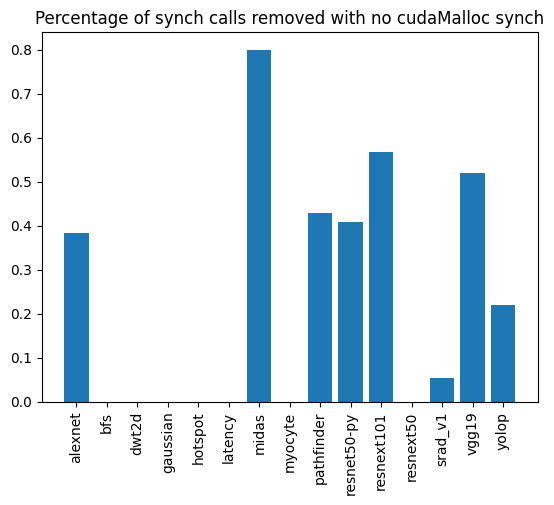

dict_keys(['alexnet', 'bfs', 'dwt2d', 'gaussian', 'hotspot', 'latency', 'midas', 'myocyte', 'pathfinder', 'resnet50-py', 'resnext101', 'resnext50', 'srad_v1', 'vgg19', 'yolop'])

In [296]:
plt.title("Percentage of synch calls removed with no cudaMalloc synch")
values = list(cudaMalloc_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(cudaMalloc_removed_synch_percentage.keys()), rotation=90)
plt.show()
cudaMalloc_removed_synch_percentage.keys()

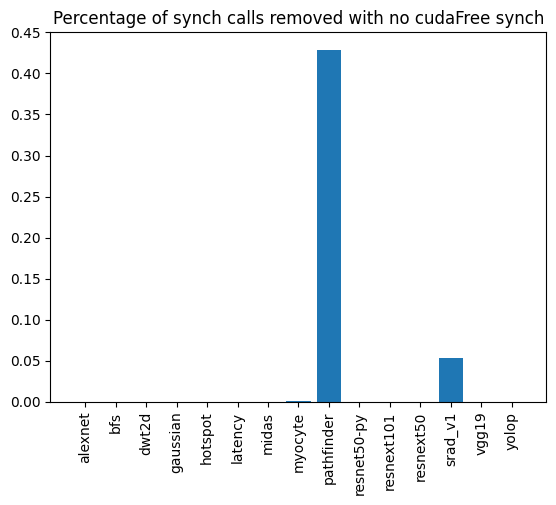

In [154]:
plt.title("Percentage of synch calls removed with no cudaFree synch")
values = list(cudaFree_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(cudaFree_removed_synch_percentage.keys()), rotation=90)
plt.show()

### Reduction of synch at every *_v7 calls

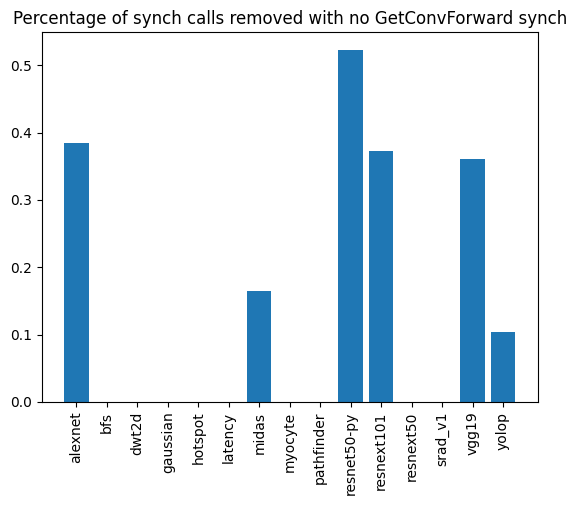

In [155]:
forward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionForwardAlgorithm_v7")

plt.title("Percentage of synch calls removed with no GetConvForward synch")
values = list(forward_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(forward_removed_synch_percentage.keys()), rotation=90)
plt.show()

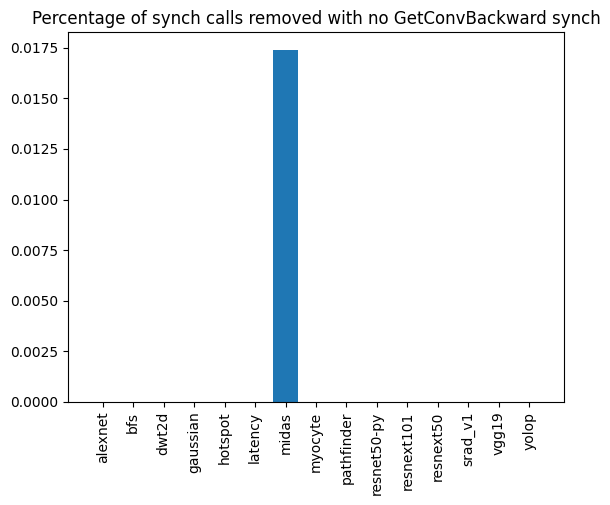

In [300]:
backward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionBackwardDataAlgorithm_v7")

plt.title("Percentage of synch calls removed with no GetConvBackward synch")
values = list(backward_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(backward_removed_synch_percentage.keys()), rotation=90)
plt.show()

## Total reduction of synch calls

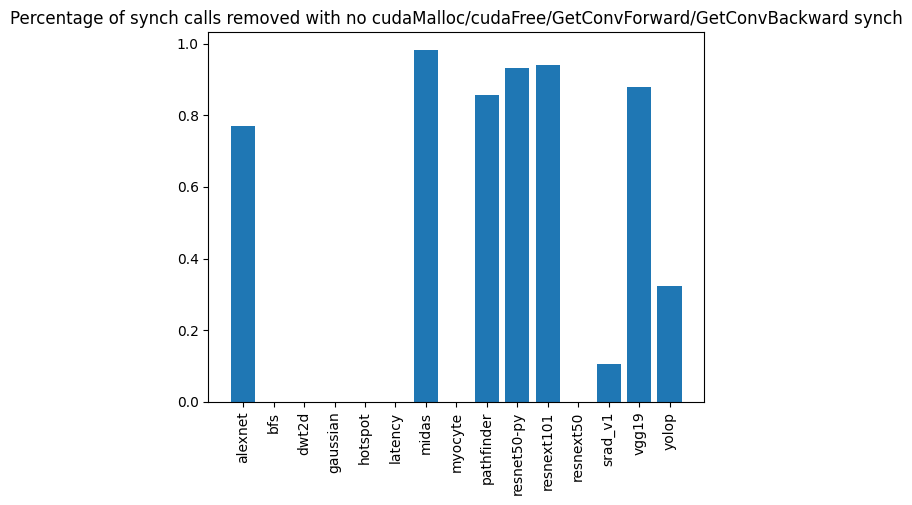

In [303]:
total_percentage_removed = percentage_removed_sync_calls_array(df, ["cudaMalloc", "cudaFree", "cudnnGetConvolutionForwardAlgorithm_v7", "cudnnGetConvolutionBackwardDataAlgorithm_v7"])

plt.title("Percentage of synch calls removed with no cudaMalloc/cudaFree/GetConvForward/GetConvBackward synch")
values = list(total_percentage_removed.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(total_percentage_removed.keys()), rotation=90)
plt.show()

In [15]:
cudaMalloc_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaMalloc")
cudaFree_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaFree")
backward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionBackwardDataAlgorithm_v7")
forward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionForwardAlgorithm_v7")

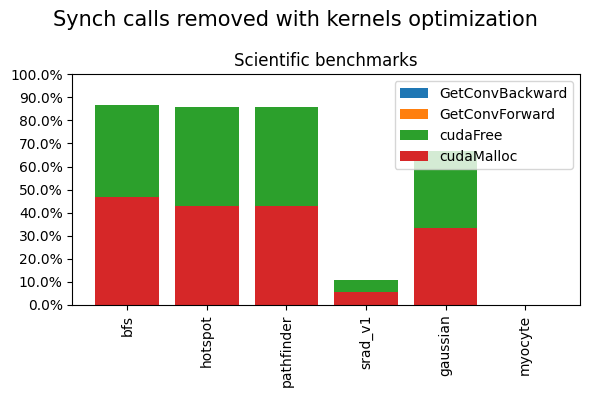

In [16]:
scientific_benchmarks = ['bfs', 'hotspot', 'pathfinder', 'srad_v1', 'gaussian', 'myocyte']
ml_benchmarks = ['alexnet', 'midas', 'resnet50-py', 'resnext101', 'vgg19', 'yolop']

# figsize 12, 8
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with kernels optimization", size=15)
plt.title("Scientific benchmarks")
# plt.bar(x, values, label="Total")
# Do an additive bar plot
values_1 = np.array([cudaMalloc_removed_synch_percentage[benchmark] for benchmark in scientific_benchmarks])
values_2 = np.array([cudaFree_removed_synch_percentage[benchmark] for benchmark in scientific_benchmarks])
values_3 = np.array([forward_removed_synch_percentage[benchmark] for benchmark in scientific_benchmarks])
values_4 = np.array([backward_removed_synch_percentage[benchmark] for benchmark in scientific_benchmarks])
keys = [benchmark for benchmark in scientific_benchmarks]
x = np.arange(len(values_1))
plt.bar(x, values_1 + values_2 + values_3 + values_4, label="GetConvBackward")
plt.bar(x, values_1 + values_2 + values_3, label="GetConvForward")
plt.bar(x, values_1 + values_2, label="cudaFree")
plt.bar(x, values_1, label="cudaMalloc")
plt.xticks(x, list(keys), rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)


plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_scientific_benchmarks.png", dpi=300)

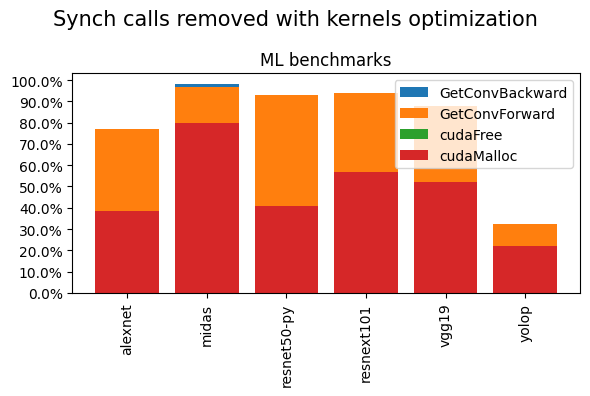

In [17]:
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with kernels optimization", size=15)
plt.title("ML benchmarks")

# Do an additive bar plot
values_1 = np.array([cudaMalloc_removed_synch_percentage[benchmark] for benchmark in ml_benchmarks])
values_2 = np.array([cudaFree_removed_synch_percentage[benchmark] for benchmark in ml_benchmarks])
values_3 = np.array([forward_removed_synch_percentage[benchmark] for benchmark in ml_benchmarks])
values_4 = np.array([backward_removed_synch_percentage[benchmark] for benchmark in ml_benchmarks])
keys = [benchmark for benchmark in ml_benchmarks]
x = np.arange(len(values_1))
plt.bar(x, values_1 + values_2 + values_3 + values_4, label="GetConvBackward")
plt.bar(x, values_1 + values_2 + values_3, label="GetConvForward")
plt.bar(x, values_1 + values_2, label="cudaFree")
plt.bar(x, values_1, label="cudaMalloc")
plt.xticks(x, list(keys), rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_ml_benchmarks.png", dpi=300)

In [18]:
# optistic execution once these synch points have been removed

no_cudaMalloc_df, _ = remove_synch_calls(df, "cudaMalloc")
no_cudaFree_df, _ = remove_synch_calls(no_cudaMalloc_df, "cudaFree")
no_forward_df, _ = remove_synch_calls(no_cudaFree_df, "cudnnGetConvolutionForwardAlgorithm_v7")
no_all_df, _ = remove_synch_calls(no_forward_df, "cudnnGetConvolutionBackwardDataAlgorithm_v7")


df_sequence = no_all_df.dropna(subset=['sequence'])
# One has to reset the index to remove benchmarks with no sequences
# df_sequence.reset_index(inplace=True)
# df_sequence.set_index(['benchmark', 'call_id'], inplace=True)
df_sequence.index.levels[0].unique()

data_1 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
data_2 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
data_3 = {'benchmark': [], 'sequence': [], 'sequence_call_id': [], 'count': [], 'call_id': []}
for benchmark in df_sequence.index.levels[0]:
    print(benchmark)
    sequence_1 = None
    sequence_2 = None
    sequence_3 = None
    sequence_1_call_id = None
    sequence_2_call_id = None
    sequence_3_call_id = None

    count_1 = 0
    count_2 = 0
    count_3 = 0

    try:
        for row in df_sequence.loc[benchmark].itertuples():
            sequence = row.sequence
            sequence_call_id = row.sequence_call_id
            call_id = row.Index
            if sequence == sequence_1:
                count_1 += 1
            elif count_1 > 0:
                data_1['benchmark'].append(benchmark)
                data_1['sequence'].append(sequence_1)
                data_1['count'].append(count_1)
                data_1['call_id'].append(call_id)
                data_1['sequence_call_id'].append(sequence_1_call_id)
                # print(sequence, count)
                count_1 = 0
            if sequence == sequence_2:
                count_2 += 1
            elif count_2 > 0:
                data_2['benchmark'].append(benchmark)
                data_2['sequence'].append(sequence_2)
                data_2['count'].append(count_2)
                data_2['call_id'].append(call_id)
                data_2['sequence_call_id'].append(sequence_2_call_id)
                # print(sequence, count)
                count_2 = 0
            if sequence == sequence_3:
                count_3 += 1
            elif count_3 > 0:
                data_3['benchmark'].append(benchmark)
                data_3['sequence'].append(sequence_3)
                data_3['count'].append(count_3)
                data_3['call_id'].append(call_id)
                data_3['sequence_call_id'].append(sequence_3_call_id)
                # print(sequence, count)
                count_3 = 0

            sequence_3 = sequence_2
            sequence_2 = sequence_1
            sequence_1 = sequence

            sequence_3_call_id = sequence_2_call_id
            sequence_2_call_id = sequence_1_call_id
            sequence_1_call_id = sequence_call_id
    except KeyError:
        print("No sequence in benchmark", benchmark)

df_1 = pd.DataFrame(data_1)
df_1['pattern'] = 1
df_2 = pd.DataFrame(data_2)
df_2['pattern'] = 2
df_3 = pd.DataFrame(data_3)
df_3['pattern'] = 3
optimistic_df = pd.concat([df_1, df_2, df_3])
optimistic_df.set_index(['benchmark', 'pattern'], inplace=True)
# Percentage among all synch calls that would benefit from being optimistically executed for each benchmark
synch_tot = df.loc[df["op"] == "Synchronization"].groupby("benchmark").count()
opti_optimistic_result_percentage = [{key: 0 for key in  optimistic_df.index.levels[0]} for _ in range(3)]

for benchmark in no_all_df.index.levels[0]:
    print(benchmark)
    for i in optimistic_df.index.levels[1]:
        try:
            opti_optimistic_result_percentage[i-1][benchmark] = optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']
            # print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")
        except KeyError: 
            opti_optimistic_result_percentage[i-1][benchmark] = 0
opti_optimistic_result_percentage


alexnet
bfs
dwt2d
No sequence in benchmark dwt2d
gaussian
hotspot
latency
No sequence in benchmark latency
midas
myocyte
pathfinder
resnet50-py
resnext101
resnext50
srad_v1
vgg19
yolop
alexnet
bfs
dwt2d


/tmp/ipykernel_24380/1210159365.py:93: PerformanceWarning: indexing past lexsort depth may impact performance.
  opti_optimistic_result_percentage[i-1][benchmark] = optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']


gaussian
hotspot
latency
midas
myocyte
pathfinder
resnet50-py
resnext101
resnext50
srad_v1
vgg19
yolop


[{'srad_v1': 0,
  'yolop': 0.375,
  'alexnet': 0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0,
  'myocyte': 0,
  'pathfinder': 0,
  'resnet50-py': 0,
  'resnext101': 0,
  'resnext50': 0,
  'vgg19': 0},
 {'srad_v1': 0.8755555555555555,
  'yolop': 0.3641304347826087,
  'alexnet': 0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0,
  'myocyte': 0,
  'pathfinder': 0,
  'resnet50-py': 0,
  'resnext101': 0,
  'resnext50': 0,
  'vgg19': 0},
 {'srad_v1': 0,
  'yolop': 0.358695652173913,
  'alexnet': 0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0,
  'myocyte': 0,
  'pathfinder': 0,
  'resnet50-py': 0,
  'resnext101': 0,
  'resnext50': 0,
  'vgg19': 0}]

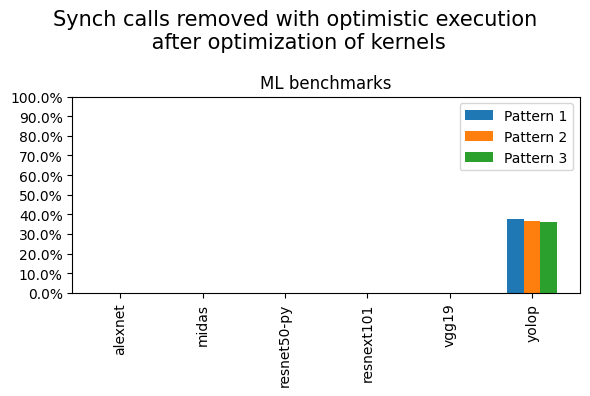

In [19]:
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with optimistic execution\n after optimization of kernels", size=15)
plt.title("ML benchmarks")

values_0 = np.array([opti_optimistic_result_percentage[0][benchmark] for benchmark in ml_benchmarks])
values_1 = np.array([opti_optimistic_result_percentage[1][benchmark] for benchmark in ml_benchmarks])
values_2 = np.array([opti_optimistic_result_percentage[2][benchmark] for benchmark in ml_benchmarks])

x = np.arange(len(ml_benchmarks))

plt.bar(x - 0.2, values_0, width=0.2, label="Pattern 1")
plt.bar(x, values_1, width=0.2, label="Pattern 2")
plt.bar(x + 0.2, values_2, width=0.2, label="Pattern 3")
plt.xticks(x, ml_benchmarks, rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_ml_benchmarks_optimistic_execution.png", dpi=300)

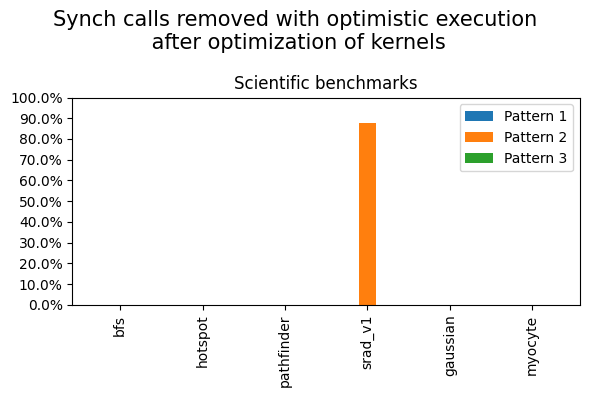

In [20]:
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with optimistic execution\n after optimization of kernels", size=15)
plt.title("Scientific benchmarks")

values_0 = np.array([opti_optimistic_result_percentage[0][benchmark] for benchmark in scientific_benchmarks])
values_1 = np.array([opti_optimistic_result_percentage[1][benchmark] for benchmark in scientific_benchmarks])
values_2 = np.array([opti_optimistic_result_percentage[2][benchmark] for benchmark in scientific_benchmarks])

x = np.arange(len(scientific_benchmarks))

plt.bar(x - 0.2, values_0, width=0.2, label="Pattern 1")
plt.bar(x, values_1, width=0.2, label="Pattern 2")
plt.bar(x + 0.2, values_2, width=0.2, label="Pattern 3")
plt.xticks(x, scientific_benchmarks, rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_scientific_benchmarks_optimistic_execution.png", dpi=300)

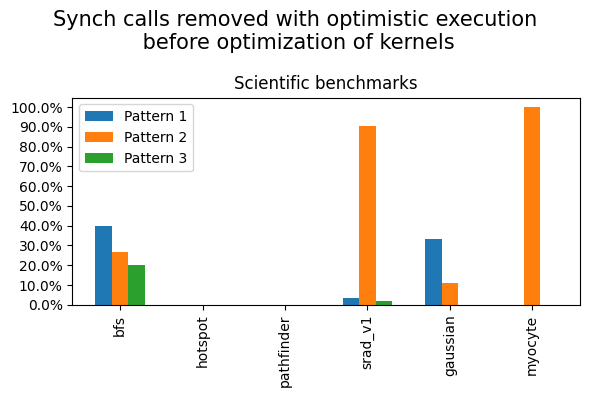

In [21]:
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with optimistic execution\n before optimization of kernels", size=15)
plt.title("Scientific benchmarks")

values_0 = np.array([optimistic_result_percentage[0][benchmark] for benchmark in scientific_benchmarks])
values_1 = np.array([optimistic_result_percentage[1][benchmark] for benchmark in scientific_benchmarks])
values_2 = np.array([optimistic_result_percentage[2][benchmark] for benchmark in scientific_benchmarks])

x = np.arange(len(scientific_benchmarks))

plt.bar(x - 0.2, values_0, width=0.2, label="Pattern 1")
plt.bar(x, values_1, width=0.2, label="Pattern 2")
plt.bar(x + 0.2, values_2, width=0.2, label="Pattern 3")
plt.xticks(x, scientific_benchmarks, rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_scientific_benchmarks_optimistic_execution_no_opti.png", dpi=300)

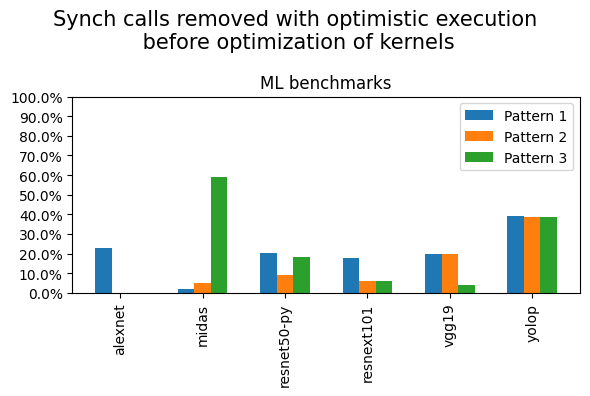

In [22]:
plt.figure(figsize=(6, 4))
plt.suptitle("Synch calls removed with optimistic execution\n before optimization of kernels", size=15)
plt.title("ML benchmarks")

values_0 = np.array([optimistic_result_percentage[0][benchmark] for benchmark in ml_benchmarks])
values_1 = np.array([optimistic_result_percentage[1][benchmark] for benchmark in ml_benchmarks])
values_2 = np.array([optimistic_result_percentage[2][benchmark] for benchmark in ml_benchmarks])

x = np.arange(len(ml_benchmarks))

plt.bar(x - 0.2, values_0, width=0.2, label="Pattern 1")
plt.bar(x, values_1, width=0.2, label="Pattern 2")
plt.bar(x + 0.2, values_2, width=0.2, label="Pattern 3")
plt.xticks(x, ml_benchmarks, rotation=90)
# yticks are percentages
plt.yticks(np.arange(0, 1.1, 0.1))
ax = plt.gca()
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

plt.legend()
plt.tight_layout()
plt.savefig("synch_calls_removed_ml_benchmarks_optimistic_execution_no_opti.png", dpi=300)

In [418]:
optimistic_df.loc['yolop'] # this is cudaMemcpyAsync synch calls, not optimizable

,sequence,sequence_call_id,count,call_id
pattern,,,,
1,"[6, 7]","[4341, 4342]",41,4368
1,"[6, 7, 2]","[4391, 4392, 4393]",1,4397
1,"[6, 7]","[4680, 4681]",95,4707
1,"[6, 7, 2]","[4730, 4731, 4732]",1,4736
2,"[6, 7]","[4338, 4339]",40,4368
2,"[6, 7]","[4677, 4678]",94,4707
3,"[6, 7]","[4335, 4336]",39,4368
3,"[6, 7]","[4674, 4675]",93,4707


In [421]:
optimistic_df.loc['srad_v1'] # this is cudaMemcpy synch calls, not optimizable

,sequence,sequence_call_id,count,call_id
pattern,,,,
2,"[1, 2, 2, 2, 2, 2]","[918, 919, 920, 921, 922, 923]",197,931
